# Overview

This is a Collaborative Filtering Approach to Energy Benchmarking. Based on a set of intuitive features, an algorithm is developed to find the N (user defined) closest neighbour of each building in the LL84 dataset.

The motivation is to find the most tailored way of "finding a peer group to compare against". Using each building as its own centroid is, I argue, the best way compare to any clustering techniques that rely on arbitray centroid (e.g. K-Means)

This script includes the following section:
- Data processing
- Similarity algorithm
- Performance benchmarking

---

## Data Ingestion and Processing

In [459]:
# Import
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

import matplotlib as plt
import matplotlib.style as style
from pandas.tools.plotting import scatter_matrix
style.use('fivethirtyeight')
%pylab inline

from IPython.display import HTML, display as d

pd.set_option('display.max_columns', 500)

Populating the interactive namespace from numpy and matplotlib


In [460]:
# Ingest data from project github
# Please see Data Processing script for detailed steps (TO BE UPLOADED)
url = "https://raw.githubusercontent.com/td928/CAUI_team1_Final_Project/master/merged-w-latlon.csv"
df = pd.read_csv(url)
df.head()

,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,Occupancy,TYPE_2016,water_intensity,naturalgas_use,Metered Areas (Energy),Metered Areas (Water),naturalgas_intensity,Borough,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,YearBuilt,XCoord,YCoord,ZipCode,Address,Longitude,Latitude
0,1011860091,60.9,63121.0,70.9,58266.0,68.6,58266.0,68.3,58266.0,100.0,Multifamily Housing,26.45,67417.0,Whole Building,Whole Building,1.157056,MN,6641,58266,0,58266,0,0,12.0,25,25,1910,989141.0,225102.0,10024.0,316 WEST 79 STREET,-73.982338,40.784528
1,1000167501,64.9,199141.0,74.2,220821.0,77.0,220821.0,76.2,220821.0,100.0,Multifamily Housing,52.01,10441275.8,Whole Building,Whole Building,47.283890,MN,16951,179174,1092,177488,0,1092,25.0,238,239,1985,979290.0,197895.0,10280.0,377 RECTOR PLACE,-74.017891,40.709851
2,1000167502,71.5,150667.0,74.8,150855.0,41.1,150855.0,74.2,150855.0,100.0,Multifamily Housing,44.60,2332818.2,Whole Building,Whole Building,15.463977,MN,27838,123284,11136,112148,0,0,15.0,133,133,1986,979379.0,197988.0,10280.0,350 ALBANY STREET,-74.017570,40.710107
3,1000167504,74.6,112312.0,77.7,91774.0,73.3,91774.0,71.7,91774.0,100.0,Multifamily Housing,39.22,4395045.3,Whole Building,Not Available,47.889874,MN,16108,72913,4295,68618,0,4295,9.0,107,110,1986,979576.0,197918.0,10280.0,300 ALBANY STREET,-74.016859,40.709915
4,1000167505,116.7,235366.0,106.2,257092.0,106.7,257092.0,101.7,257092.0,100.0,Multifamily Housing,56.40,16783196.3,Whole Building,Not Available,65.280897,MN,23910,203837,1177,202660,1177,0,26.0,246,247,1987,979243.0,197613.0,10280.0,380 RECTOR PLACE,-74.018060,40.709077


In [461]:
df.dtypes

BBL                         int64
EUI_2013                  float64
floorArea_2013            float64
EUI_2014                  float64
floorArea_2014            float64
EUI_2015                  float64
floorArea_2015            float64
EUI_2016                  float64
floorArea_2016            float64
Occupancy                 float64
TYPE_2016                  object
water_intensity           float64
naturalgas_use            float64
Metered Areas (Energy)     object
Metered Areas  (Water)     object
naturalgas_intensity      float64
Borough                    object
LotArea                     int64
BldgArea                    int64
ComArea                     int64
ResArea                     int64
OfficeArea                  int64
RetailArea                  int64
NumFloors                 float64
UnitsRes                    int64
UnitsTotal                  int64
YearBuilt                   int64
XCoord                    float64
YCoord                    float64
ZipCode       

In [462]:
# Create a Age feature based on Built Year
df["age"] = datetime.datetime.now().year - df['YearBuilt']

# Create Average EUI of 2013, 2014, and 2015
df["avgEUI"] = df[['EUI_2013', 'EUI_2014', 'EUI_2015']].mean(axis=1)

df.head(10)

,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,Occupancy,TYPE_2016,water_intensity,naturalgas_use,Metered Areas (Energy),Metered Areas (Water),naturalgas_intensity,Borough,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,YearBuilt,XCoord,YCoord,ZipCode,Address,Longitude,Latitude,age,avgEUI
0,1011860091,60.9,63121.0,70.9,58266.0,68.6,58266.0,68.3,58266.0,100.0,Multifamily Housing,26.45,67417.0,Whole Building,Whole Building,1.157056,MN,6641,58266,0,58266,0,0,12.0,25,25,1910,989141.0,225102.0,10024.0,316 WEST 79 STREET,-73.982338,40.784528,107,66.800000
1,1000167501,64.9,199141.0,74.2,220821.0,77.0,220821.0,76.2,220821.0,100.0,Multifamily Housing,52.01,10441275.8,Whole Building,Whole Building,47.283890,MN,16951,179174,1092,177488,0,1092,25.0,238,239,1985,979290.0,197895.0,10280.0,377 RECTOR PLACE,-74.017891,40.709851,32,72.033333
2,1000167502,71.5,150667.0,74.8,150855.0,41.1,150855.0,74.2,150855.0,100.0,Multifamily Housing,44.60,2332818.2,Whole Building,Whole Building,15.463977,MN,27838,123284,11136,112148,0,0,15.0,133,133,1986,979379.0,197988.0,10280.0,350 ALBANY STREET,-74.017570,40.710107,31,62.466667
3,1000167504,74.6,112312.0,77.7,91774.0,73.3,91774.0,71.7,91774.0,100.0,Multifamily Housing,39.22,4395045.3,Whole Building,Not Available,47.889874,MN,16108,72913,4295,68618,0,4295,9.0,107,110,1986,979576.0,197918.0,10280.0,300 ALBANY STREET,-74.016859,40.709915,31,75.200000
4,1000167505,116.7,235366.0,106.2,257092.0,106.7,257092.0,101.7,257092.0,100.0,Multifamily Housing,56.40,16783196.3,Whole Building,Not Available,65.280897,MN,23910,203837,1177,202660,1177,0,26.0,246,247,1987,979243.0,197613.0,10280.0,380 RECTOR PLACE,-74.018060,40.709077,30,109.866667
5,1000167506,77.3,111398.0,80.2,106631.0,80.3,106631.0,77.2,106631.0,100.0,Multifamily Housing,41.26,5756290.8,Whole Building,Whole Building,53.983277,MN,15000,81667,502,81165,0,502,9.0,121,122,1985,979576.0,197463.0,10280.0,280 RECTOR PLACE,-74.016859,40.708666,32,79.266667
6,1000167507,56.6,163863.0,62.0,129176.0,62.1,129176.0,61.9,129176.0,100.0,Multifamily Housing,43.29,6951841.3,Whole Building,Whole Building,53.816818,MN,25978,106271,3168,103103,0,3168,9.0,153,154,1986,979385.0,197552.0,10280.0,300 RECTOR PLACE,-74.017548,40.708910,31,60.233333
7,1000167508,91.6,517639.0,93.1,590974.0,93.3,590974.0,86.9,590974.0,100.0,Multifamily Housing,48.08,31758766.1,Whole Building,Whole Building,53.739701,MN,37248,428589,4750,423839,1640,3110,44.0,545,547,1987,979703.0,197392.0,10280.0,200 RECTOR PLACE,-74.016401,40.708471,30,92.666667
8,1000167509,160.0,225262.0,108.1,237270.0,89.0,237270.0,100.0,237270.0,100.0,Multifamily Housing,69.24,11837980.8,Whole Building,Not Available,49.892447,MN,45203,194762,32279,162483,0,28464,9.0,182,184,1988,979227.0,197334.0,10280.0,21 SOUTH END AVENUE,-74.018117,40.708312,29,119.033333
9,1000167510,66.9,296200.0,74.7,348953.0,80.3,348953.0,78.3,348953.0,100.0,Multifamily Housing,40.76,15207412.8,Whole Building,Whole Building,43.580118,MN,24167,251929,7464,244465,6885,0,28.0,293,294,1988,979649.0,197083.0,10280.0,99 BATTERY PLACE,-74.016595,40.707623,29,73.966667


In [463]:
# Create a unique list of BBL

uni_BBL = df[["BBL", "Longitude", "Latitude", "age", "BldgArea", "UnitsTotal"]].drop_duplicates()
uni_BBL.shape

(3217, 6)

In [464]:
# Drop rows with any missing value and only select multi family
model_df = df.dropna()
model_df = model_df[(model_df.TYPE_2016 == 'Multifamily Housing')]
print("Number of Records in the Modelling Dataset: {}".format(model_df.shape[0]))

Number of Records in the Modelling Dataset: 3538


In [465]:
model_df.columns

Index([u'BBL', u'EUI_2013', u'floorArea_2013', u'EUI_2014', u'floorArea_2014',
       u'EUI_2015', u'floorArea_2015', u'EUI_2016', u'floorArea_2016',
       u'Occupancy', u'TYPE_2016', u'water_intensity', u'naturalgas_use',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'naturalgas_intensity', u'Borough', u'LotArea', u'BldgArea',
       u'ComArea', u'ResArea', u'OfficeArea', u'RetailArea', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'YearBuilt', u'XCoord', u'YCoord',
       u'ZipCode', u'Address', u'Longitude', u'Latitude', u'age', u'avgEUI'],
      dtype='object')

In [466]:
dist_features = ["BBL", "EUI_2016", "floorArea_2016", "Occupancy", "UnitsTotal", "age", "avgEUI"]
model_df = model_df[dist_features]
model_df = model_df.set_index("BBL")

In [468]:
# Remove Duplicated Rows by Taking a Max() Aggregation
model_df = model_df.groupby("BBL").max().reset_index()
print("--- Number of Rows: {}".format(model_df.shape[0]))

# Reserve a unique list of BBL
list_bbl = model_df['BBL']

# Set BBL as Index
model_df = model_df.set_index("BBL")
model_df.head(10)

--- Number of Rows: 3217


,EUI_2016,floorArea_2016,Occupancy,UnitsTotal,age,avgEUI
BBL,,,,,,
1000110014,76.3,51387.0,100.0,21,108,77.366667
1000167501,76.2,220821.0,100.0,239,32,72.033333
1000167502,74.2,150855.0,100.0,133,31,62.466667
1000167504,71.7,91774.0,100.0,110,31,75.200000
1000167505,101.7,257092.0,100.0,247,30,109.866667
1000167506,77.2,106631.0,100.0,122,32,79.266667
1000167507,61.9,129176.0,100.0,154,31,60.233333
1000167508,86.9,590974.0,100.0,547,30,92.666667
1000167509,100.0,237270.0,100.0,184,29,119.033333


In [469]:
list_bbl[0:10]

0    1000110014
1    1000167501
2    1000167502
3    1000167504
4    1000167505
5    1000167506
6    1000167507
7    1000167508
8    1000167509
9    1000167510
Name: BBL, dtype: int64

---

# Similarity Algorithm
5 Most Used Similarity Metrics

http://dataaspirant.com/2015/04/11/five-most-popular-similarity-measures-implementation-in-python/

In [475]:
# Create a Pairwise Distance Matrix
from sklearn.metrics.pairwise import euclidean_distances
dist = euclidean_distances(model_df, model_df)

In [476]:
import pprint as pprint
pprint.pprint(dist[0:10])

array([[      0.        ,  169434.15737228,   99468.09399712, ...,
          40953.19275575,  103473.11462939,   27516.26641988],
       [ 169434.15737228,       0.        ,   69966.08098587, ...,
         128481.06927252,   65961.06494171,  141918.0765244 ],
       [  99468.09399712,   69966.08098587,       0.        , ...,
          58515.01483252,    4005.34332625,   71952.02285725],
       ..., 
       [ 539587.26233618,  370153.12887672,  440119.19593598, ...,
         498634.19337442,  436114.17630194,  512071.19919499],
       [ 185883.09443519,   16449.17658851,   86415.0374381 , ...,
         144930.02360435,   82410.01350672,  158367.04747709],
       [ 297566.1357439 ,  128132.01187115,  198098.065811  , ...,
         256613.06830497,  194093.05307397,  270050.0745622 ]])


In [477]:
dist.shape

(3217, 3217)

In [478]:
model_df.index

Int64Index([1000110014, 1000167501, 1000167502, 1000167504, 1000167505,
            1000167506, 1000167507, 1000167508, 1000167509, 1000167510,
            ...
            5005890035, 5005890044, 5005890053, 5006107502, 5024527501,
            5028320017, 5028627501, 5028670214, 5028770025, 5035437501],
           dtype='int64', name=u'BBL', length=3217)

In [479]:
model_df.head(10)

,EUI_2016,floorArea_2016,Occupancy,UnitsTotal,age,avgEUI
BBL,,,,,,
1000110014,76.3,51387.0,100.0,21,108,77.366667
1000167501,76.2,220821.0,100.0,239,32,72.033333
1000167502,74.2,150855.0,100.0,133,31,62.466667
1000167504,71.7,91774.0,100.0,110,31,75.200000
1000167505,101.7,257092.0,100.0,247,30,109.866667
1000167506,77.2,106631.0,100.0,122,32,79.266667
1000167507,61.9,129176.0,100.0,154,31,60.233333
1000167508,86.9,590974.0,100.0,547,30,92.666667
1000167509,100.0,237270.0,100.0,184,29,119.033333


In [480]:
# Reset Index
model_df = model_df.reset_index()

In [482]:
# Convert Data Frame to Dictionary 
model_df = model_df.reset_index()
bbl_dict = model_df.to_dict('index')
bbl_dict[0]

{'BBL': 1000110014.0,
 'EUI_2016': 76.299999999999997,
 'Occupancy': 100.0,
 'UnitsTotal': 21.0,
 'age': 108.0,
 'avgEUI': 77.366666666666674,
 'floorArea_2016': 51387.0,
 'index': 0.0,
 'level_0': 0.0}

In [493]:
# Find N Closest Neighbour for Each Building based on Distance Matrix

def findBBL(dist, n):
    
    '''
    This returns top n most similar BBL of each BBL
    Input: Pair-wise Distance Matrix, n = number of neighbours (max cannot exceed len(dist))
    Output: List of each BBL and its N closest neighbours
    '''
    
    top_BBL = []
    
    for i in range(0, len(dist)):
        # insert BBL into dict as the key
        # find index of closest n BBL
        # extract the details of the closest n BBL
        # create dictionary element of each BBL and its closest neighbours
        building = dist[i]
        closest_idx = building.argsort()[-len(tmp):][::-1][-n-1:-1][::-1] #[index of most clostest, 2nd closest, 3rd closest ...]
        
        top_BBL.append({"Self":bbl_dict[i],
                        "Neighbours":[bbl_dict[a] for a in closest_idx]})
        
    return top_BBL

sim_BBL = findBBL(dist, 5)

In [494]:
# Calculate Average EUI of all Neighbour BBLs and EER

def calAvgEUI(sim_BBL):
    
    '''This Calculates average EUI of all Neighbouring BBL'''
    
    for i in range(0, len(sim_BBL)):
        EUI_array = np.array([sim_BBL[i]['Neighbours'][j]['EUI_2016'] for j in range(0, len(sim_BBL[i]['Neighbours']))])
        sim_BBL[i]["NBAvgEUI"] = EUI_array.mean()
        sim_BBL[i]["EER"] = sim_BBL[i]['Self']['EUI_2016'] / sim_BBL[i]["NBAvgEUI"]
    
    return sim_BBL

sim_BBL = calAvgEUI(sim_BBL)

In [496]:
# Inspect some Samples

sim_BBL[0:2]

[{'EER': 0.79744983277591974,
  'NBAvgEUI': 95.679999999999993,
  'Neighbours': [{'BBL': 1011200061.0,
    'EUI_2016': 66.700000000000003,
    'Occupancy': 100.0,
    'UnitsTotal': 58.0,
    'age': 93.0,
    'avgEUI': 64.100000000000009,
    'floorArea_2016': 51428.0,
    'index': 382.0,
    'level_0': 382.0},
   {'BBL': 2048220021.0,
    'EUI_2016': 86.5,
    'Occupancy': 100.0,
    'UnitsTotal': 61.0,
    'age': 89.0,
    'avgEUI': 99.600000000000009,
    'floorArea_2016': 51354.0,
    'index': 1800.0,
    'level_0': 1800.0},
   {'BBL': 3053570045.0,
    'EUI_2016': 91.400000000000006,
    'Occupancy': 100.0,
    'UnitsTotal': 54.0,
    'age': 88.0,
    'avgEUI': 98.866666666666674,
    'floorArea_2016': 51426.0,
    'index': 2249.0,
    'level_0': 2249.0},
   {'BBL': 3051500021.0,
    'EUI_2016': 120.40000000000001,
    'Occupancy': 100.0,
    'UnitsTotal': 40.0,
    'age': 94.0,
    'avgEUI': 121.56666666666668,
    'floorArea_2016': 51396.0,
    'index': 2199.0,
    'level_0': 219

In [498]:
# Test STD for a range of N Neighbours to Find the Optimal (if any)

n_range = [30, 50, 100, 300, 500, 800, 1000, 1500, 1800, 2000, 2200]
EER_df = pd.DataFrame()
std_list = []

for n in n_range:
    EER_list = []
    print("Running for n: {}".format(n))
    sim_BBL = findBBL(dist, n)
    sim_BBL = calAvgEUI(sim_BBL)
    EER = [sim_BBL[i]["EER"] for i in range(0, len(sim_BBL))]
    
    # Append to a Data Frame
    col_name = "EER_"+str(n)
    EER_df[col_name] = EER
    
    # Append to STD list
    
    std_list.append(np.std(np.array(EER)))
    
    del sim_BBL

EER_df.describe()

Running for n: 30
Running for n: 50
Running for n: 100
Running for n: 300
Running for n: 500
Running for n: 800
Running for n: 1000
Running for n: 1500
Running for n: 1800
Running for n: 2000
Running for n: 2200


,EER_30,EER_50,EER_100,EER_300,EER_500,EER_800,EER_1000,EER_1500,EER_1800,EER_2000,EER_2200
count,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000
mean,1.298482,1.323906,1.374722,1.315580,1.264118,1.200828,1.222330,1.192961,1.221883,1.222226,1.191485
std,13.289889,13.836458,15.012471,10.417635,11.595041,9.217263,10.064645,11.375933,12.107679,12.325651,12.648860
min,0.004553,0.004661,0.004756,0.004939,0.003217,0.003683,0.002334,0.002095,0.002308,0.002434,0.002540
25%,0.815158,0.815536,0.814363,0.790686,0.661611,0.645615,0.655125,0.520778,0.541869,0.556997,0.562274
50%,0.974899,0.974568,0.975714,0.951787,0.876855,0.874540,0.871271,0.794472,0.792513,0.789303,0.743712
75%,1.163827,1.157790,1.155636,1.137566,1.076496,1.069900,1.063894,1.025535,1.020689,1.017415,0.945470
max,746.834005,774.740563,833.552139,511.168350,541.743352,339.041668,384.627796,466.375202,501.236012,520.316723,537.247905


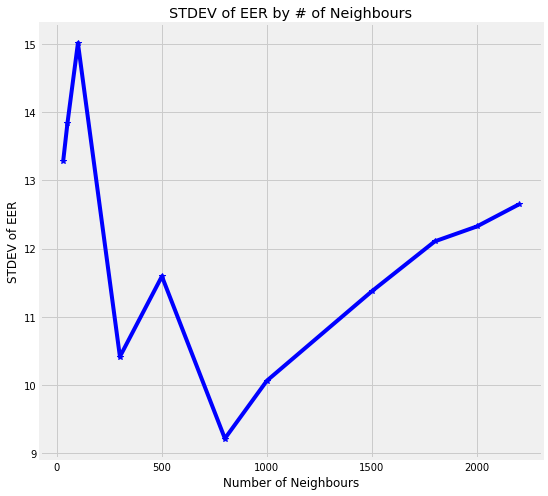

In [499]:
fig = plt.figure(figsize = (8, 8));
ax = fig.add_subplot(111);
ax.plot(n_range, std_list, 'b*-');
plt.grid(True);
plt.xlabel('Number of Neighbours');
plt.ylabel('STDEV of EER');
plt.title('STDEV of EER by # of Neighbours');